In [3]:
import numpy as np
import scipy
import pandas as pd
import pybedtools as pb

# figs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150
import seaborn as sns


#import h5py
#import allel

# my libs
import EnrichRLib as erl
import RNA_expression_processing as rn
import Enh_Mut_Manip as emm

# warnings
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter("ignore", ResourceWarning)

In [4]:
### == Math functions == 
def log2p1(x):
    return np.log2(x + 1)

In [5]:
# Project settings
from os.path import join 
WORKDIR = '/home/sergio/Res_CIML/TLX3_project'
SCRIPTS = join(WORKDIR,'scripts')
DATADIR = join(WORKDIR,'data')
WGS = join(DATADIR,'tracks/WGS-WES/Germline')
RP = join(DATADIR,'tracks/MARGE/relativeRP/bam_input')



# Data loading

### Regulatory potentials based on H3K27ac -- TLX3-vs-RAG

In [6]:
# Regulatory Potentials
fn_rag = join(DATADIR,'tracks/TSS_RAG_H3K27ac_RP_3K.csv')
fn_tlx = join(DATADIR,'tracks/TSS_TLX3_H3K27ac_RP_3K.csv')

tlx_27ac = pd.read_csv(fn_tlx, index_col=0)
rag_27ac = pd.read_csv(fn_rag, index_col=0)

tlx_27ac.rename(columns={'potential':'RP_tlx'}, inplace=True)
rag_27ac.rename(columns={'potential':'RP_rag'}, inplace=True)

tlx_rag_27ac = pd.concat([tlx_27ac,rag_27ac.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

tlx_rag_27ac.drop_duplicates(subset='name', inplace=True)

tlx_rag_27ac = tlx_rag_27ac[(tlx_rag_27ac['RP_rag']>0) | (tlx_rag_27ac['RP_tlx']>0)]


Ap,Bp = 'RP_tlx','RP_rag'
cols = ['name', Ap, Bp]

rp_3K = tlx_rag_27ac[cols]

rp_3K = rp_3K.set_index(keys=rp_3K.columns[0])

rp_3K = rp_3K.apply(pd.to_numeric)


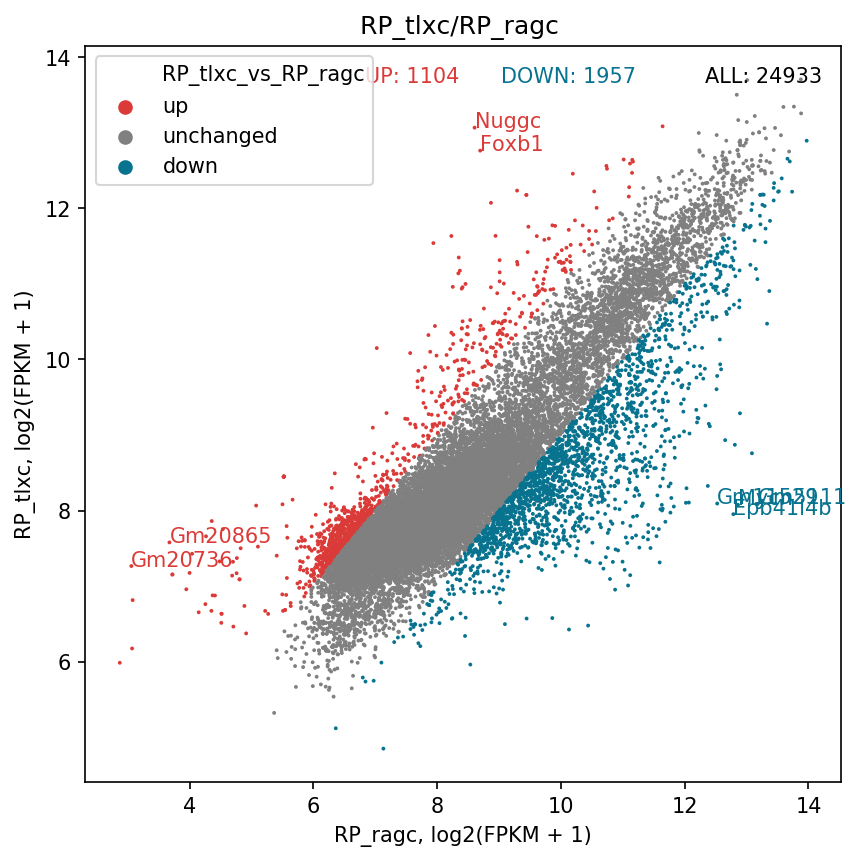

In [7]:
# classes
Ac = Ap+'c'
Bc = Bp+'c'
classe = [Ap+'c', Bp+'c']

up, dn, ax = rn.scatter_n(rp_3K, Ac, Bc, 
                    classes=classe, 
                    n_top=4)

In [8]:
#len(up)

### RNA-expression table TLX3-vs-RAG

In [9]:
## == Expression table TLX3 vs RAG
tbl = pd.read_table(join(DATADIR,'tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
expr = tbn.set_index(keys=tbn.columns[0])
#expr.index = expr.index.str.upper()

# RAG: Story ZERO 
# DN_RP(TLX3vsRAG)-->DN_Express(TLX3vsRAG)

![title](im/Prom_Story0R.png)

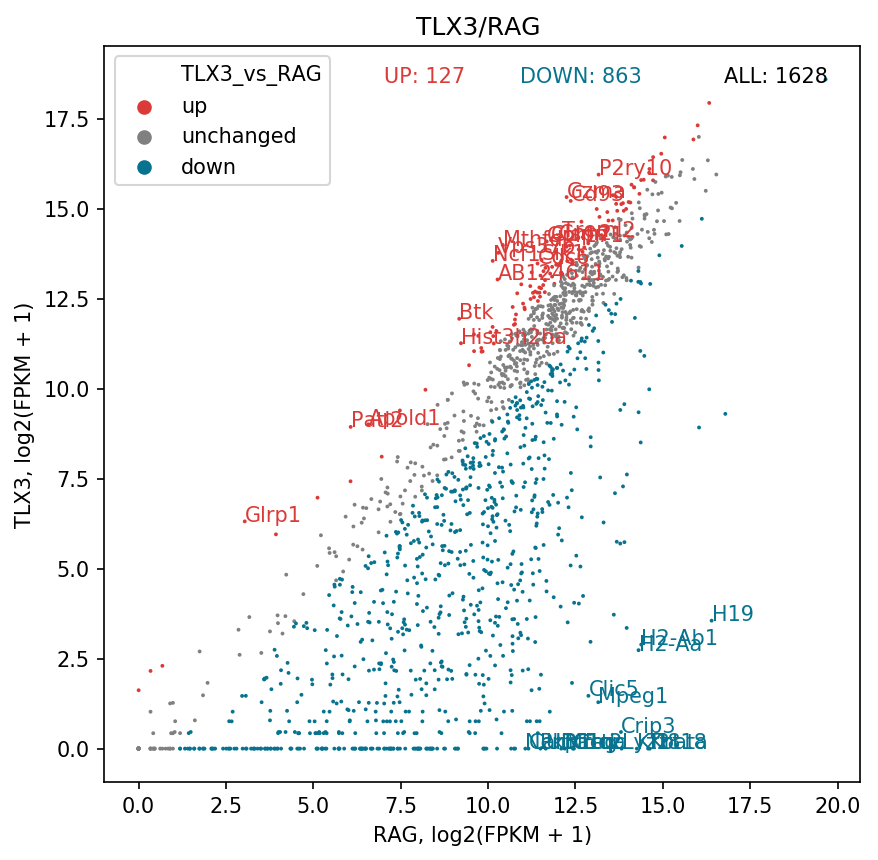

In [10]:
# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

gl_dn = list(dn.index)

tmp=rn.scatter_n(expr[expr.index.isin(gl_dn)], A, B,classes=classes, n_top=18)

### Enrichment

In [15]:
## Enrichment analysis
# List of gene sets 
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016',
       'Cancer_Cell_Line_Encyclopedia',
       #'MSigDB_Computational',
       'MSigDB_Oncogenic_Signatures',
       'NCI-60_Cancer_Cell_Lines',
       'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
       ]

In [16]:
## Two analysis possible

#dn_genes = gl_up # genes with UP H3K27ac TLX3-vs-RAG 

dn_genes = list(tmp[1].index) # ONLY DNregulated genes from genes with UP H3K27ac TLX3-vs-RAG 

DN_genes = [x.upper() for x in dn_genes]

enr = erl.enrich_gs(DN_genes,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 2718
GO_Cellular_Component_2018 193
GO_Molecular_Function_2018 540
KEGG_2016 249
Reactome_2016 772
Cancer_Cell_Line_Encyclopedia 936
MSigDB_Oncogenic_Signatures 186
NCI-60_Cancer_Cell_Lines 92
RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO 1297


In [50]:
def cluser_enrich(enr,gl,pval=0.05, top_clusters=20, spring=150):
    #2= Filter terms by p-Val
    enr = enr[enr['p-Val']<pval]

    #3= Make claster by kappa coeff
    enr = erl.cluster(set(gl), enr, deep=2)

    #3-1= Filter top clusters
    enr = enr[enr['cluster']<top_clusters]

    #4= Make clustered geneset 
    gs_clust,nt_cl = erl.cluster_genset(enr)

    #5= Enrich clustered geneset
    enr_clust = erl.enrich(gl,gs_clust)
    
    # deduplicate index -- TODO!!! in package
    nt_cl = nt_cl.loc[~nt_cl.index.duplicated(keep='first')]

    #6= Add cluster to table
    enr_clust = pd.concat([enr_clust,nt_cl.loc[enr_clust.index]['cluster']],axis=1, sort=False)

    #7= Make graphs
    G_gs = erl.make_graph_n(gl,enr, kappa=0.4)
    G_cl = erl.make_graph_n(gl,enr_clust, kappa=0.01)

    #8= Draw graphs
    erl.draw_graph(G_gs, spring=spring)
    erl.draw_direct(G_cl)



    #9= Draw barplot for clustered terms
    enr.sort_values('cluster', axis=0, inplace = True)

    cm = ('tab20' if max(enr['cluster'])>10  else 'tab10')

    f, ax = plt.subplots(figsize=(8, 24))
    sns.barplot(y=enr.index,
                x='-log10(p-Val)',
                ax = ax, 
                hue ='cluster',
                dodge=False,
                data = enr,
                palette = cm)
    ax.set_title('Top terms in clusters ')

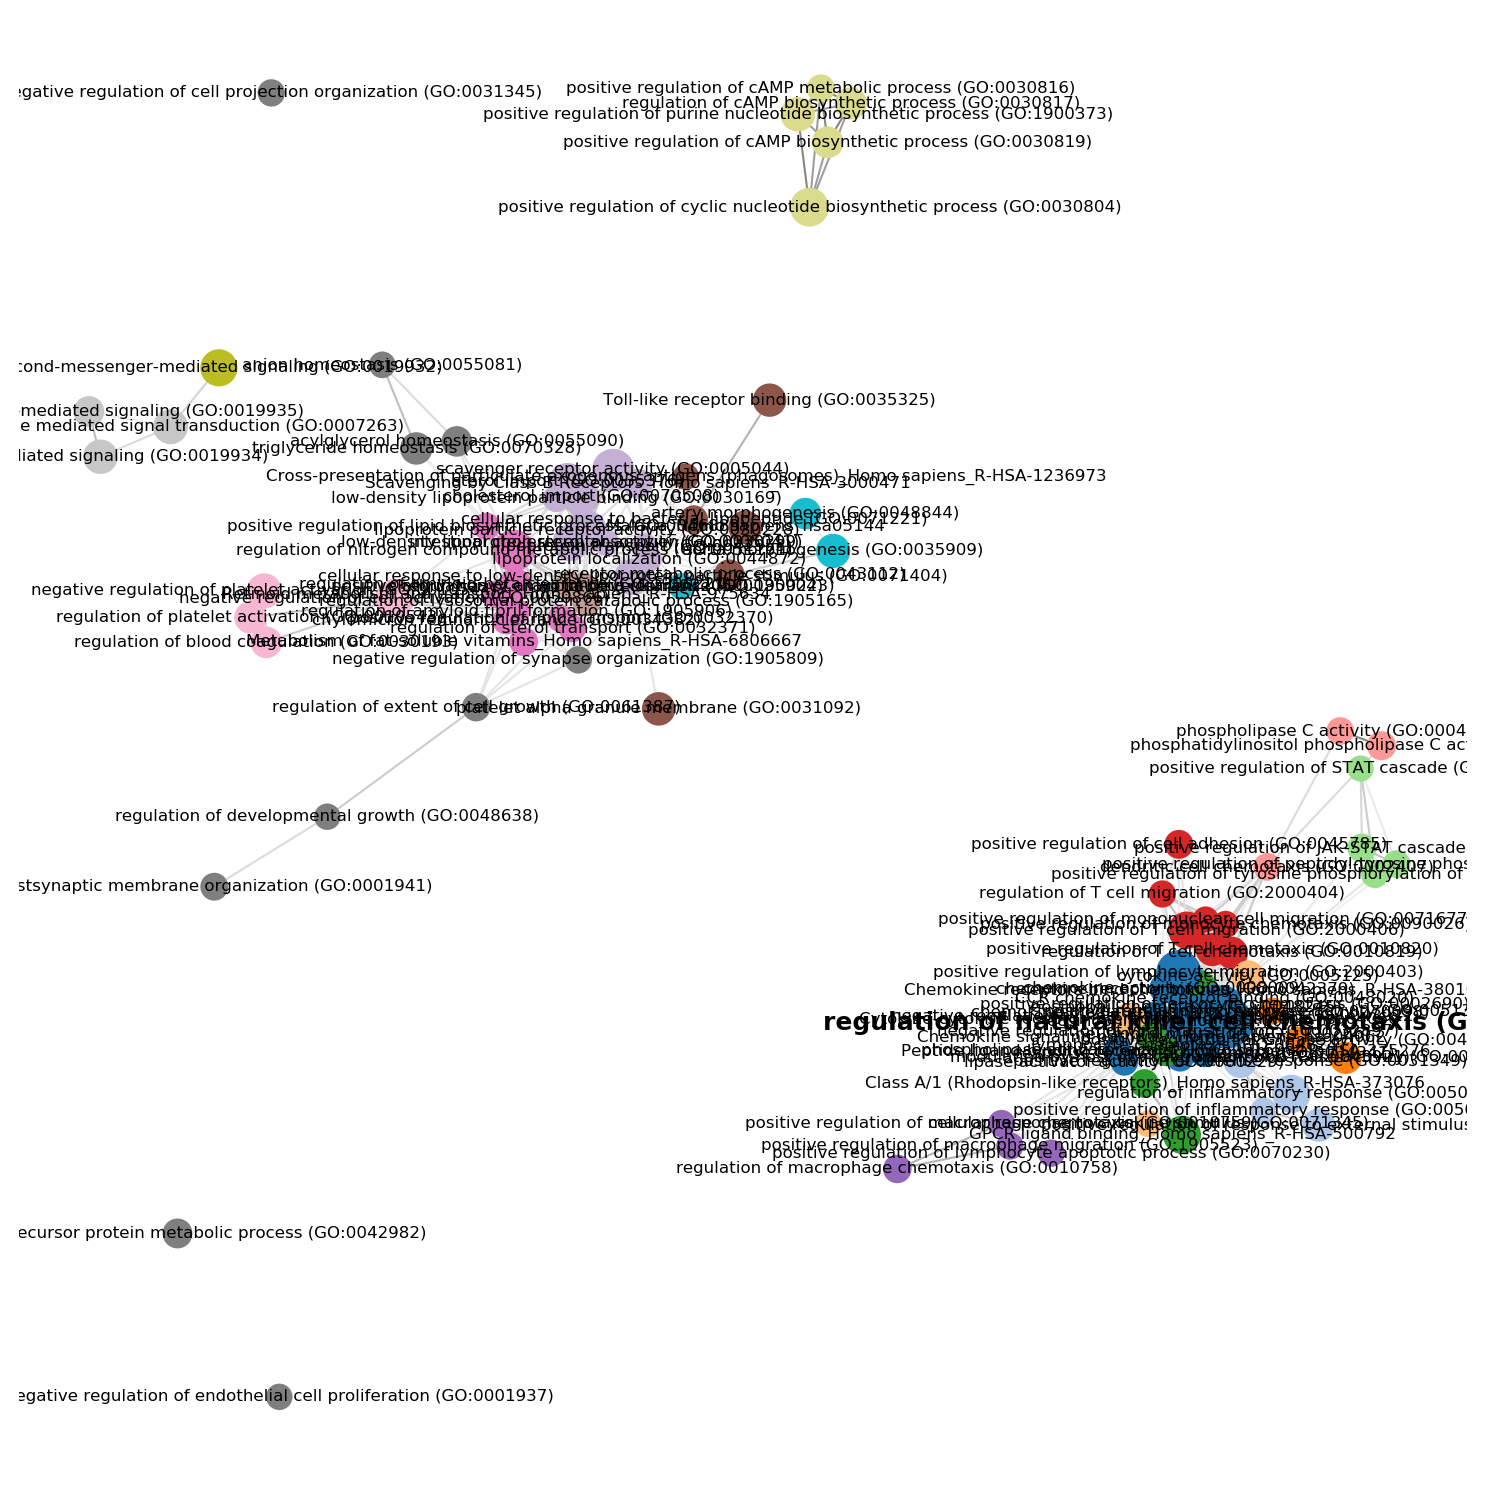

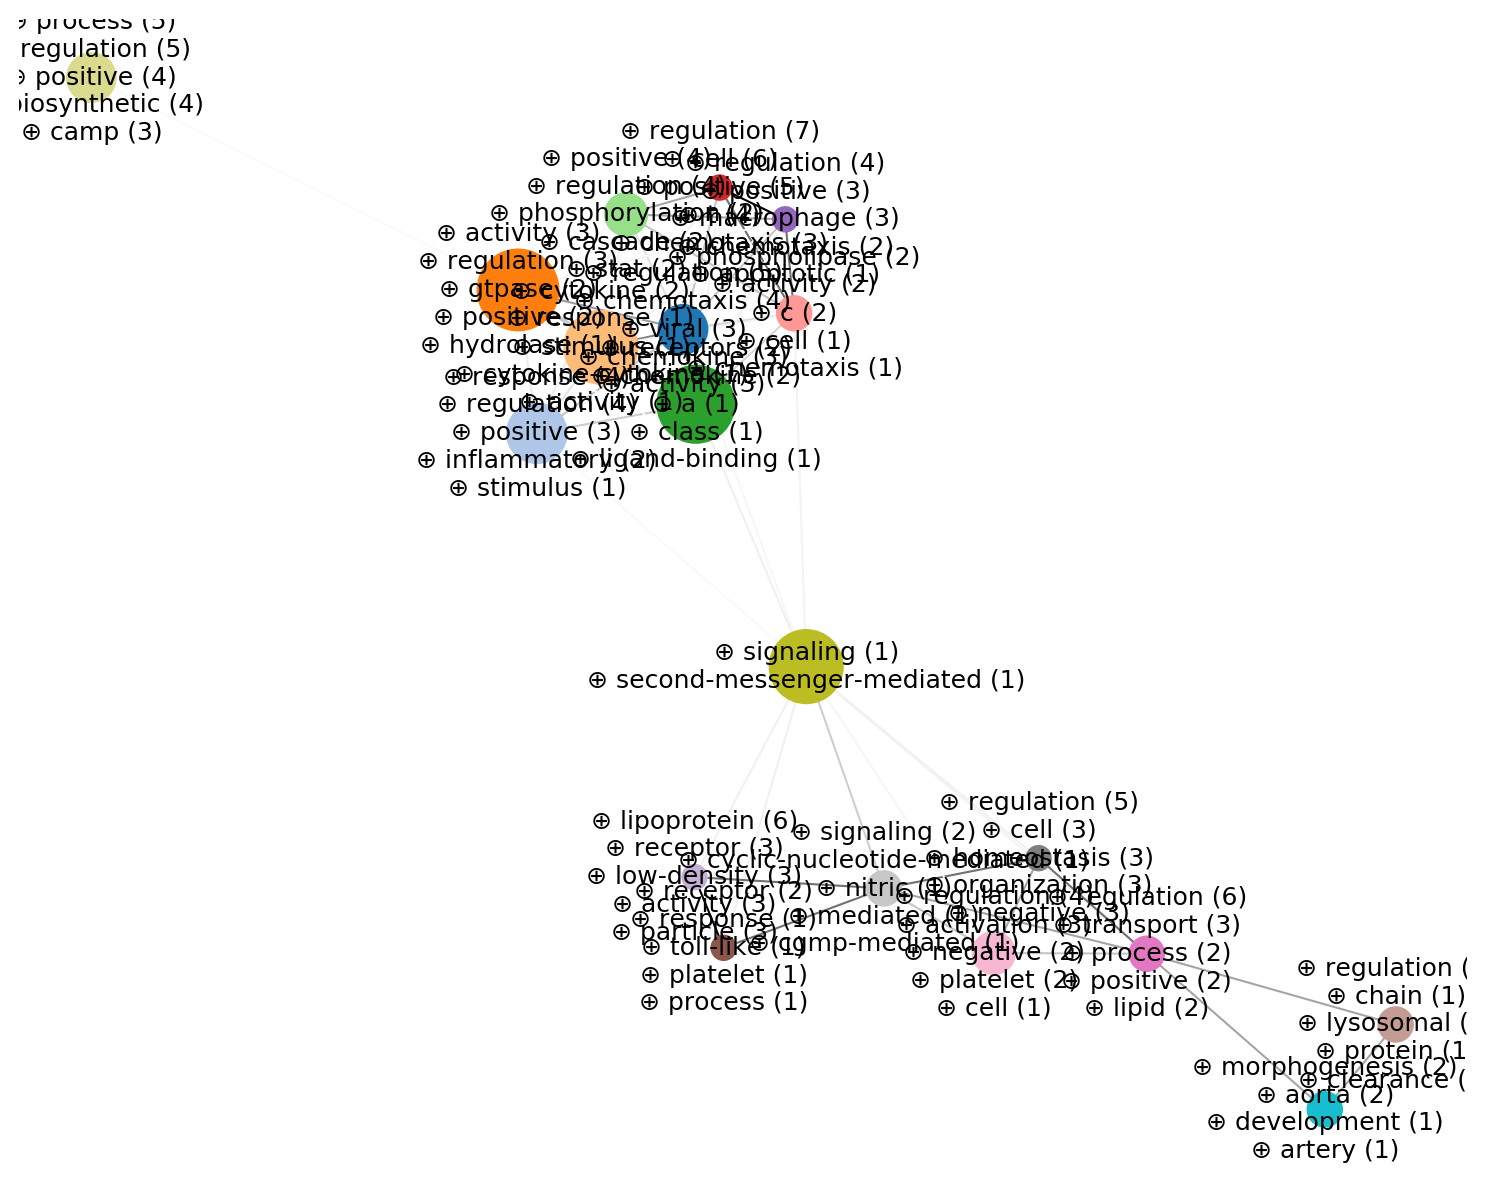

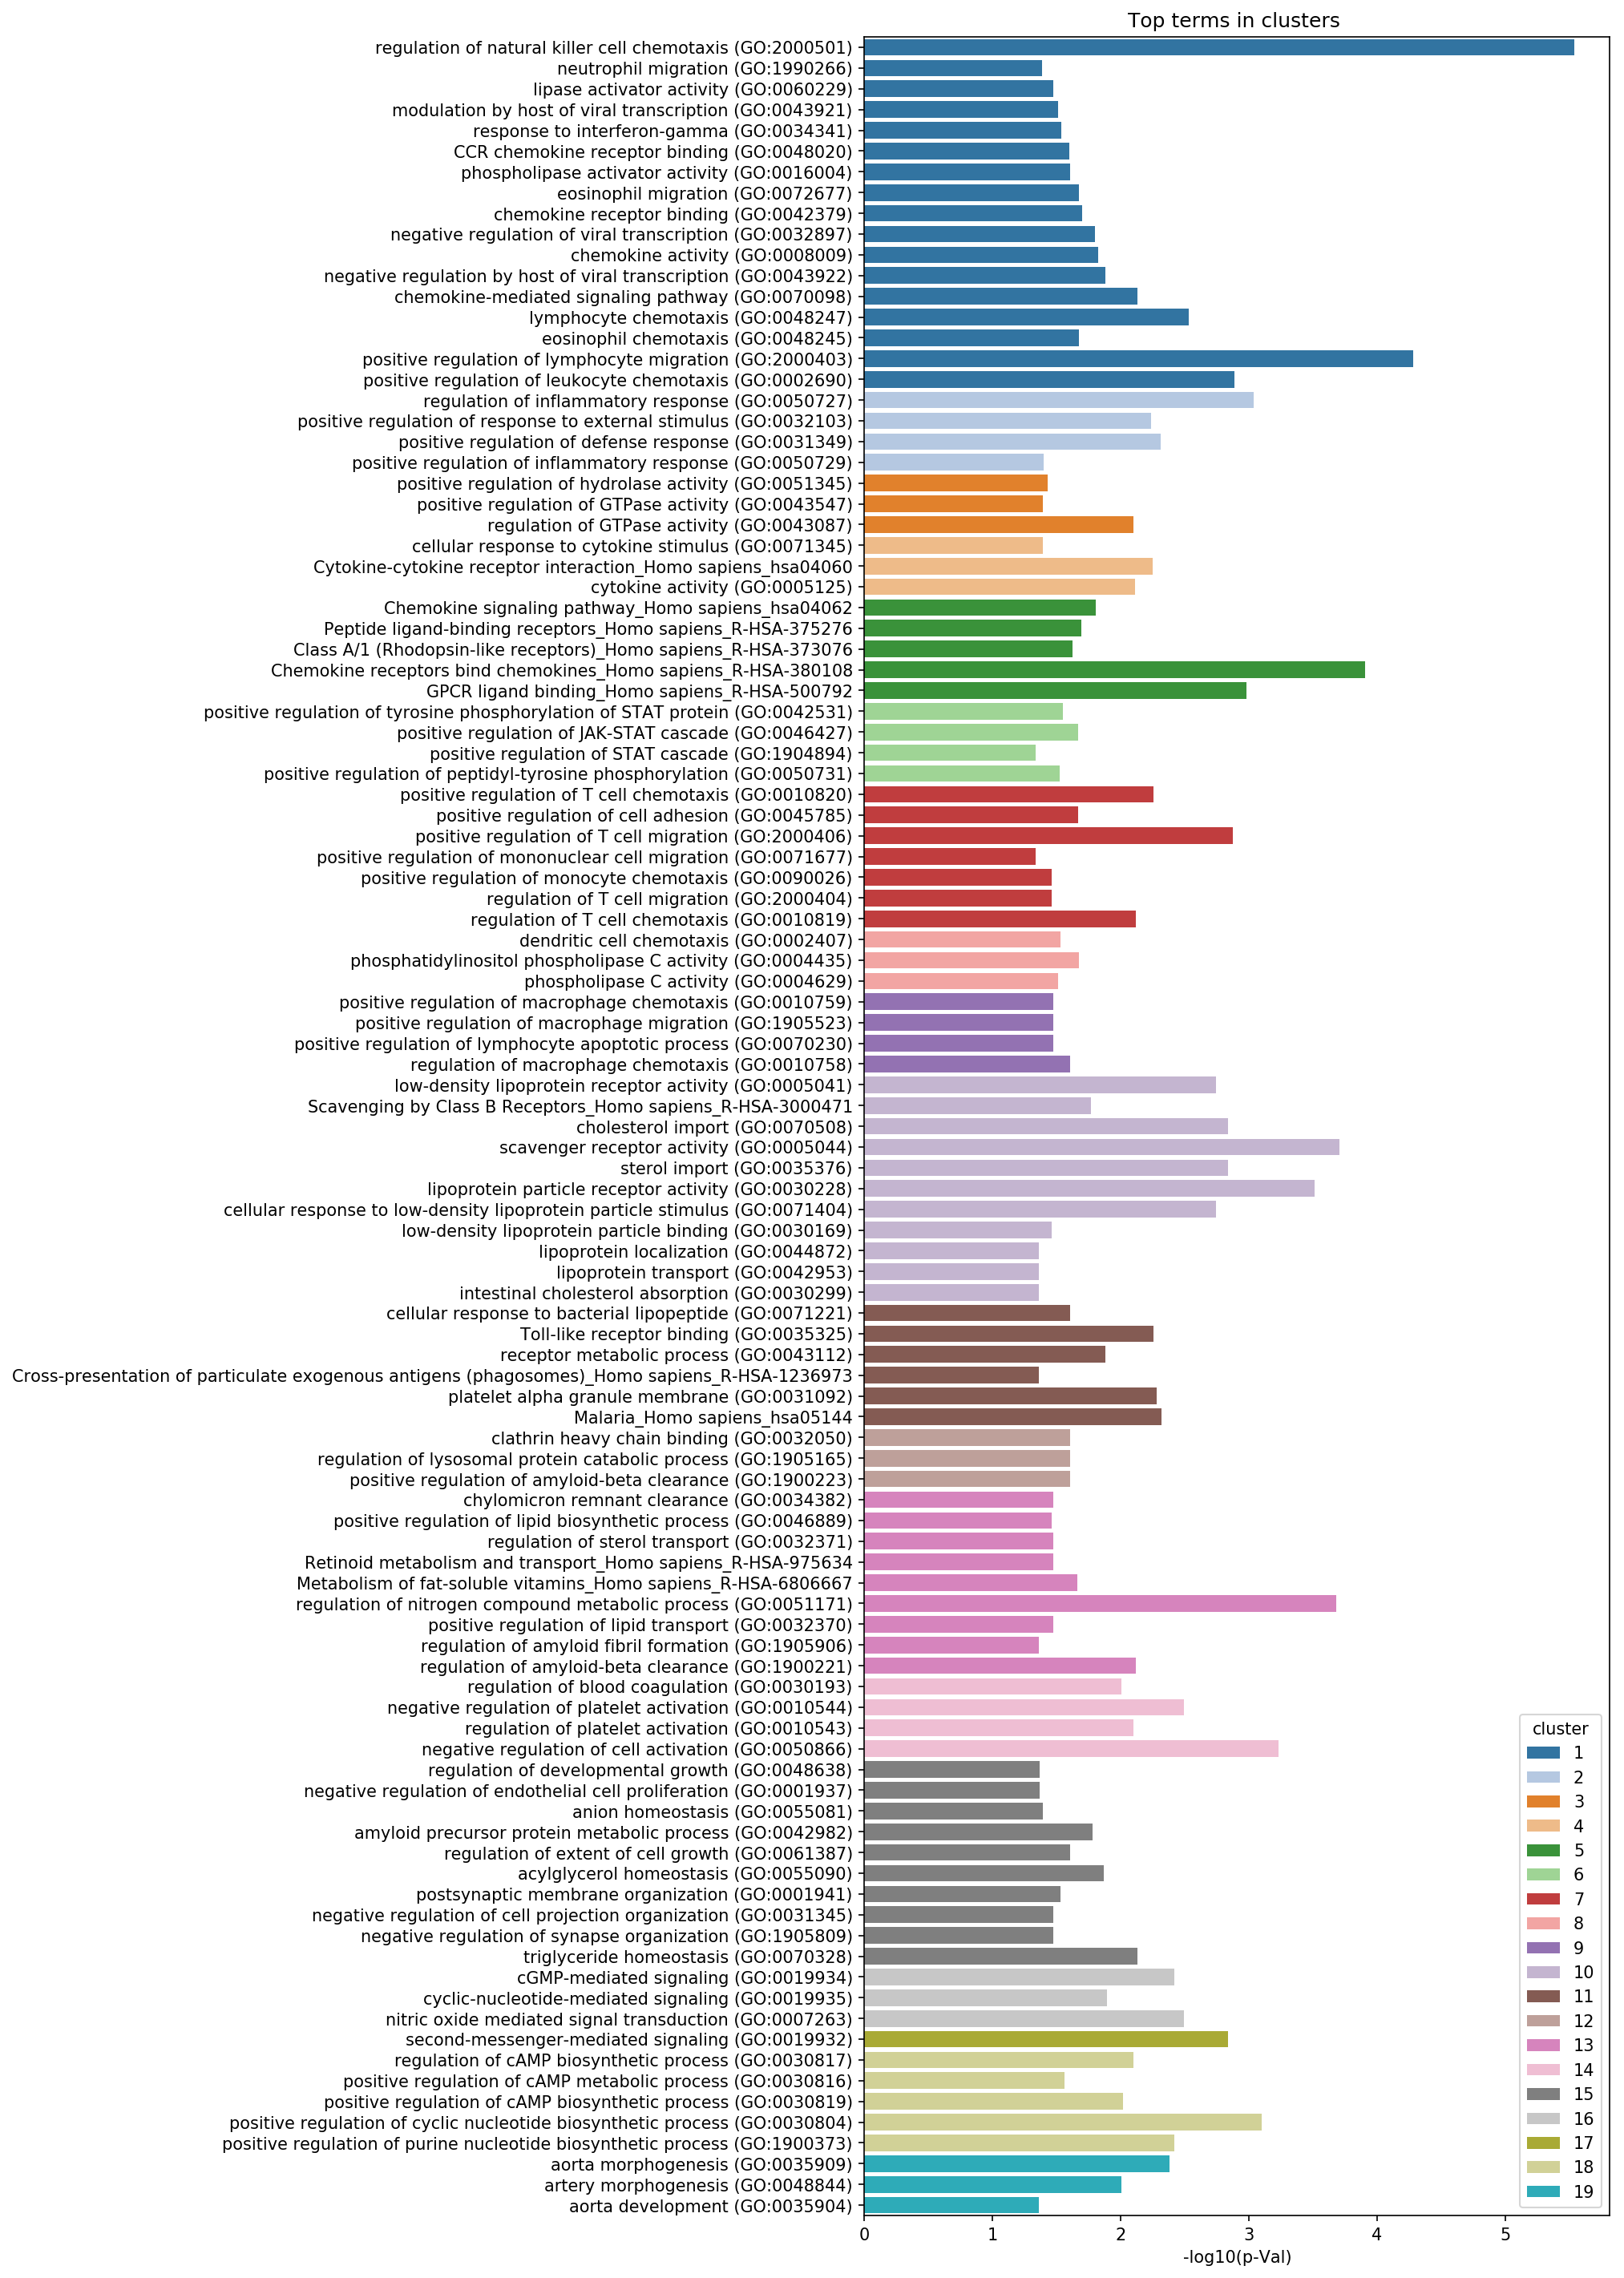

In [51]:
# Clusters and barplot

cluser_enrich(enr,DN_genes)

# RAG: Story ONE -- TLX3 peaks

![title](im/Prom_Story1R.png)

In [18]:
## Load TLX peaks file
#colm9 = ['chr_mm9','start_mm9','end_mm9', 'gene_name']
tlx_peak = pb.BedTool(join(DATADIR,'tracks/TLX3_TLX3_peaks.bed'))
sl = 100
tlx_peak = tlx_peak.slop(b=sl, genome='mm9')

In [19]:
### == DN analysis
tss =  3000
colm9 = ['chrom','start','end', 'name']
dn_rp = tlx_rag_27ac.loc[tlx_rag_27ac['name'].isin(list(dn_genes))]
#dn_rp = dn_rp[dn_rp['end_mm9']-dn_rp['start_mm9']>0]
dn_rp = pb.BedTool.from_dataframe(dn_rp[colm9])
dn_rp = dn_rp.slop(b=tss, genome='mm9')


dn_rp_tlx = dn_rp+tlx_peak
dn_rp_gene = dn_rp_tlx.to_dataframe()

dnTLX_list =list(dn_rp_gene['name'])
dnTLX_list.sort()

In [20]:
print('Genes with DN RP and upregulated:\n',list(dn_genes))
print(':===================================================================:')
print('Genes with DN RP and upregulated and TLX3 peaks:\n',list(dnTLX_list))

Genes with DN RP and upregulated:
 ['Vkorc1', 'E330017L17Rik', 'Foxn4', 'Tifab', 'Tk2', 'H2-Q4', 'Wfdc5', 'Ldlr', 'Hook2', 'AA986860', 'Gm10804', 'F730035M05Rik', 'Alad', 'Gm11520', 'Calcoco1', 'Malat1', 'Car14', 'Pnpo', 'Adcy6', 'Caskin1', 'Tspan3', 'Tnfsf10', 'Phospho1', 'Agtrap', 'Hes7', '0610005C13Rik', 'Per2', 'Katnal1', 'Tmem9', 'Neu1', 'Mir3470b', '2810410L24Rik', 'Fstl3', 'Cd200r3', 'Jazf1', 'F2rl2', 'Ctsw', 'Fam83a', 'Usp51', 'Tmsb15b1', 'D830013O20Rik', 'BC049352', 'Pld4', 'Nudt22', 'Tmem221', 'Btbd6', 'Pth1r', 'Mfsd12', 'Sema4c', 'Tnfrsf14', 'Loxl2', '0610039K10Rik', 'Eif4e3', 'Taf1c', 'Fstl1', 'Fam83f', 'Adam1b', 'Isg15', '2610307P16Rik', 'A630023P12Rik', 'Cst3', 'Tmem82', 'Nav1', '9330136K24Rik', 'Zmiz1', 'Dcdc2b', 'Zfp3', '2900052L18Rik', 'Gm16537', 'Nfkb2', 'Lrrc1', 'Phf21a', 'Ehd3', 'Gm10684', 'Lrch4', '1700017J07Rik', 'Ctsa', 'Thra', 'Rab3gap2', 'Gm15401', 'Unc93b1', 'Armc7', 'Gm13889', 'Trafd1', 'Map3k14', 'Txnip', '4933404O12Rik', 'Cd3g', 'Fbxl12', 'Chsy1', 'Gsdmd', 

# RAG: Story TWO -- TLX3 mutations

![title](im/Prom_Story2R.png)

In [21]:
## == Genome vcf
tlx_gn = pb.BedTool(join(WGS,'TLX3_WGS.vcf.gz'))

tss =  2000
## TSS of active promoters
dn_prom = tlx_rag_27ac.loc[tlx_rag_27ac['name'].isin(list(gl_dn))]
#dn_prom = dn_prom[dn_prom['end_mm9']-dn_prom['start_mm9']==1]
dn_promB = pb.BedTool.from_dataframe(dn_prom[colm9])
dn_promB = dn_promB.slop(b=tss, genome='mm9')


In [22]:
# Count variants in promoters

prom_mut_counts = emm.variants_bed_counts(tlx_gn,dn_promB)
prom_mut_counts = prom_mut_counts.to_dataframe()
prom_mut_counts_srt = prom_mut_counts.sort_values('score', ascending=False)

#prom_mut_counts.head(20)

In [23]:
dn_prom['mut_score'] = prom_mut_counts['score'].values

In [24]:
#dn_prom.head(20)

In [25]:
#cpp = {'up':(0.86, 0.23, 0.22), 'unchanged':(0.5,0.5,0.5),'down':(0.03, 0.45, 0.56)}

# f1, ax1 = plt.subplots(figsize=(6.5, 6.5))
# sns.scatterplot(x = 'lgFC_TLXvsRAG', 
#                     y = 'mut_score', 
#                     #hue=diff, 
#                     data=dn_prom, 
#                     ax=ax1, 
#  #                   palette=cpp, 
#                     linewidth=0, 
#                     s=3.4)
# ax1.set_title('Genes for DN promoters with high mutation rate')

Text(0.5,1,'Genes for DN promoters with high mutation rate')

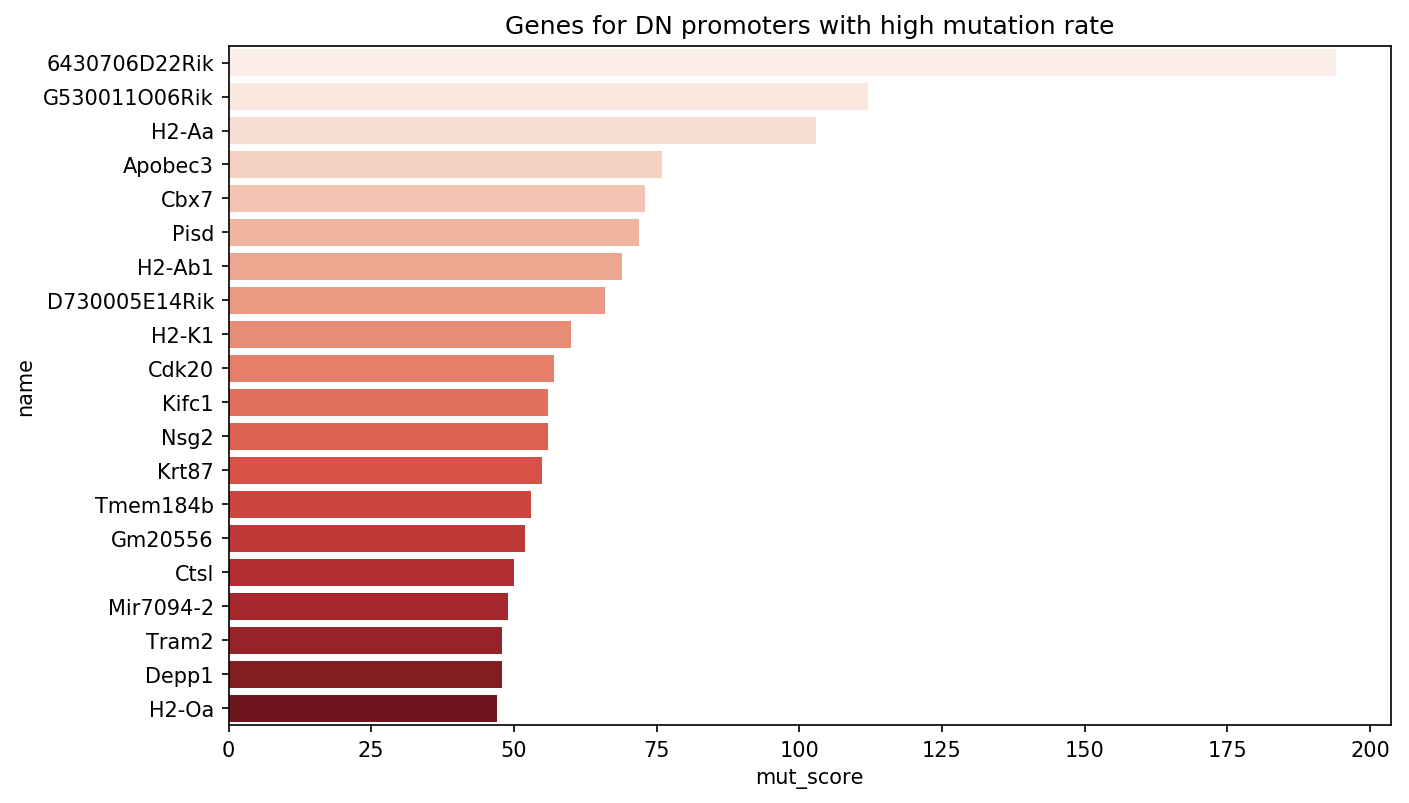

In [26]:
dn_mut_rp = dn_prom.sort_values('mut_score', ascending=False).head(20)#.sort_values('lgFC_TLXvsRAG', ascending=False)

cm = 'Reds'
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='name',
            x='mut_score',
            ax = ax, 
            #hue ='lgFC_TLXvsRAG',
            dodge=False,
            data = dn_mut_rp ,
            palette = cm)
ax.set_title('Genes for DN promoters with high mutation rate')

# Motifs around mutations in active promoters

In [27]:
# Motifs models DB
db_f = '/home/sergio/tools/deepbind/db/db.tsv'

db = pd.read_csv(db_f, sep='\t',comment="#", index_col=0)
db = db[db['Labels'].isnull()]
db.drop(columns=['Class','Experiment Details','Model','Cite','Labels','Path','Comment'], inplace=True)

# Select on TFs in mouse
db_tf = db[db['Type']=='TF']
db_tf = db_tf[db_tf['Species']=='Mus musculus']

In [28]:
# Reference genome fasta
from pyfaidx import Fasta
fn = '/home/sergio/media/NAS4/PFlab/TLX3_project/WES-seq/references/mouse_mm9_reference_genome.fa'
fa = Fasta(fn)

In [29]:
# Variant inside active promoters
prom_mut_tlx = emm.bed_variants(tlx_gn,dn_promB)
print('Variants from TLX3 WGS in inactive promoters = ', len(prom_mut_tlx))


# Save only if new analysis done
prom_mut_tlx.saveas(join(WGS,'Promoter_Inactive_TLX3_mut.vcf'))

# Load as table
import allel
prom_mut_tlx_tb = allel.vcf_to_dataframe(join(WGS,'Promoter_Inactive_TLX3_mut.vcf'),fields='*', numbers={'ALT': 4}, transformers=allel.ANNTransformer())

Variants from TLX3 WGS in inactive promoters =  6969


In [30]:
# mut_tb = prom_mut_tlx_tb[['CHROM', 'POS', 'REF', 'ALT_1','is_snp']]
# mut_tb = mut_tb.assign(REF_Prot="",
#                        REF_score_ref = np.nan,
#                        REF_score_alt = np.nan,
#                        REF_model = "",
#                        ALT_Prot="", 
#                        ALT_score_ref = np.nan,
#                        ALT_score_alt = np.nan,
#                        ALT_model = "")
# cols = ['CHROM', 'POS', 'REF', 'ALT_1', 'is_snp', 
#         'REF_Prot', 'REF_model', 'REF_score_ref','REF_score_alt', 
#         'ALT_Prot', 'ALT_model', 'ALT_score_ref', 'ALT_score_alt']

# mut_tb = mut_tb[cols]

# pad = 10

# # Cycling
# for i in range(len(mut_tb)):
#     var= mut_tb.loc[i]

#     ln = len(var['REF'])
#     rg = fa[var['CHROM']][int(var['POS'])-pad:int(var['POS'])+ln+pad]

#     pos = var['POS'] - rg.start
#     ref = var['REF'].upper()
#     alt = var['ALT_1'].upper()

#     fs = rg.seq.upper()
#     fm = emm.mut(fs,pos,ref,alt)

#     ### Find best model
#     dv = db_tf.copy()

#     dv['score_ref'] = list(emm.deepbind_list(list(dv.index),fs)['score'])
#     dv['score_alt'] = list(emm.deepbind_list(list(dv.index),fm)['score'])
#     dv_r = dv.sort_values('score_ref',axis=0, ascending=False)
#     dv_a = dv.sort_values('score_alt',axis=0, ascending=False)



#     mut_tb['REF_Prot'].loc[i] = dv_r.iloc[0]['Protein']
#     mut_tb['REF_score_ref'].loc[i] = dv_r.iloc[0]['score_ref']
#     mut_tb['REF_score_alt'].loc[i] = dv_r.iloc[0]['score_alt'] 
#     mut_tb['REF_model'].loc[i] = dv_r.index[0] 


#     mut_tb['ALT_Prot'].loc[i] = dv_a.iloc[0]['Protein'] 
#     mut_tb['ALT_score_ref'].loc[i] = dv_a.iloc[0]['score_ref']
#     mut_tb['ALT_score_alt'].loc[i] = dv_a.iloc[0]['score_alt']
#     mut_tb['ALT_model'].loc[i] = dv_a.index[0] 


# mut_tb.to_csv(join(WGS,'Variants_Promoter_Inactive_Motifs_scores.csv'))

In [31]:
mut_tb = pd.DataFrame.from_csv(join(WGS,'Variants_Promoter_Inactive_Motifs_scores.csv'))


### Select motifs with high score and ones which change TFBS
#### Sort selected motifs by score changes caused by mutation

In [32]:
mut_tb_fltr = mut_tb[(mut_tb['REF_Prot'] != mut_tb['ALT_Prot']) & (mut_tb['REF_score_ref']>2)]
mut_tb_fltr['REF_score_diff'] = mut_tb_fltr['REF_score_ref'] - mut_tb_fltr['REF_score_alt']

mut_tb_fltr_srt = mut_tb_fltr.sort_values('REF_score_diff',axis=0, ascending=False)

In [33]:
mut_tb_fltr_srt.head(10)

CHROM        POS                                                REF  \
2903  chr15  101859559                                      CGGGGGGGGGGGG   
3913  chr17   34452536                                                  T   
1670  chr12  114399051                                         CGGGGGGGGG   
3005  chr16   95929116  TGGGGTGTATATGTATGTGATGCCTGTGTATATGTGTATATATGGT...   
4537  chr19   25743900                                           CGGGGGGG   
4854   chr3  115824053                                                  T   
3334  chr17   31991807                                                  C   
3912  chr17   34452533                                                 CA   
3179  chr17   27158539                                                  G   
4519  chr19   16391112                                                  C   

     ALT_1  is_snp REF_Prot   REF_model  REF_score_ref  REF_score_alt  \
2903     C   False   Znf740  D00083.001      29.009970      -0.052036   
3913   TCA   False     Sox6  D00039.001      28.140224       0.267043   
1670     C   False   Znf740  D00083.001      26.423664      -0.062230   
3005     T   False   Znf740  D00083.001      24.978239      -0.043520   
4537     C   False   Znf740  D00083.001      24.579271       2.890682   
4854     C    True     Sox6  D00039.001      21.353783      -0.110418   
3334     G    True   Znf740  D00083.001      18.009005      -0.074972   
3912     C   False     Sox6  D00039.001      17.516697       0.093961   
3179     C    True   Znf740  D00083.001      17.238766       0.497731   
4519     A    True     Sox6  D00039.001      17.045650       0.854596   

     ALT_Prot   ALT_model  ALT_score_ref  ALT_score_alt  REF_score_diff  
2903     Egr3  D00058.001       5.290792       1.823354       29.062006  
3913   Zfp740  D00718.002       0.366337       1.372428       27.873181  
1670     Rfx7  D00072.001       2.449875      10.609684       26.485894  
3005     Dlx1  D00333.004       0.366947       1.289611       25.021759  
4537      Sp1  D00017.001       8.937601       7.651636       21.688589  
4854    Cebpb  D00001.001       0.337600       7.505086       21.464201  
3334     Klf8  D00025.001      -0.238377       4.952310       18.083977  
3912     Tbx5  D00044.001       1.297302       3.565375       17.422736  
3179   Zfp202  D00047.001       8.386364       5.143992       16.741035  
4519    Foxc2  D00061.001       3.449110       4.421881       16.191054

## Find promoters with TFS changes and associated genes

In [34]:
# Back to bed and enhancers list
mut_bd = mut_tb_fltr_srt[mut_tb_fltr_srt['REF_score_diff']>1][['CHROM','POS','REF','REF_Prot']]


mut_bd['POS_end'] = mut_bd['POS']+mut_bd['REF'].apply(len)
mut_bd = mut_bd[['CHROM','POS','POS_end', 'REF_Prot']]

mut_tf = pb.BedTool.from_dataframe(mut_bd).sort()


In [35]:
#len(up_promB)

In [36]:
mut_tf_prom = dn_promB.intersect(mut_tf,wb=True).to_dataframe()
mut_tf_prom.drop(columns=['score','strand','thickStart'], inplace=True)
mut_tf_prom.rename(columns={'thickEnd':'protein'}, inplace=True)

In [37]:
mut_tf_prom_dd = mut_tf_prom.drop_duplicates()

In [38]:
print('Genes with promoters with TFBS cahnges:\n', list(mut_tf_prom_dd['name'].unique()))

Genes with promoters with TFBS cahnges:
 ['Prex2', 'Msc', '6720483E21Rik', 'Tram2', 'Khdc1c', 'Hs6st1', 'Tmem131', 'Tbc1d8', 'Creg2', 'Bivm', 'Mreg', 'Tns1', 'Catip', 'A630095N17Rik', '6430706D22Rik', 'Mgat5', 'Pik3c2b', 'Arl8a', 'Rnpep', 'Csrp1', 'Phlda3', 'Cdc73', 'Creg1', 'Pex19', 'Vsig8', 'Vmn1r1', '4930405J17Rik', 'Rpl32l', 'Ntn4', 'Gm15915', 'Lyz2', 'Mir8104', 'Ctdsp2', 'Arhgap9', 'Rtn4', 'Nsg2', 'Stk10', 'Rnf145', 'Gm12250', 'Gm12253', 'Olfr313', 'Slc47a2', 'Tmem102', 'G630025P09Rik', 'Slc13a2os', 'Spag9', 'Hoxb3os', 'Hoxb2', 'Msl1', 'LOC666331', 'Rhbdf2', 'Slc25a10', 'Fam49a', 'Mycn', 'Pqlc3', 'Hpcal1', 'F730035M05Rik', 'Frmd6', 'Zfp36l1', 'Adck1', 'Evl', 'Slc25a29', 'Xrcc3', 'Zfyve21', 'Ppp1r13b', '5033406O09Rik', 'Mir203', 'Kif26a', 'Adssl1', 'Akt1', 'Pld4', 'Cdca4', 'Gpr132', 'Jag2', 'Mir6941', 'Nudt14', 'Btbd6', 'Pacs2', 'Crip1', 'Tedc1', 'Tmem121', 'Mir7094-1', 'Mir7094-2', 'Mir6388', 'Arl10', 'Hk3', 'Dok3', 'Tifab', '1810034E14Rik', 'Ctsl', 'Cdk20', 'Tmem171', '4833420G17

In [39]:
genes_mut_tf_prom = [x.upper() for x in list(mut_tf_prom_dd['name'].unique())]

enr_genes_mut_tf_prom = erl.enrich_gs(genes_mut_tf_prom,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 1681
GO_Cellular_Component_2018 155
GO_Molecular_Function_2018 357
KEGG_2016 173
Reactome_2016 563
Cancer_Cell_Line_Encyclopedia 752
MSigDB_Oncogenic_Signatures 159
NCI-60_Cancer_Cell_Lines 88
RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO 1301


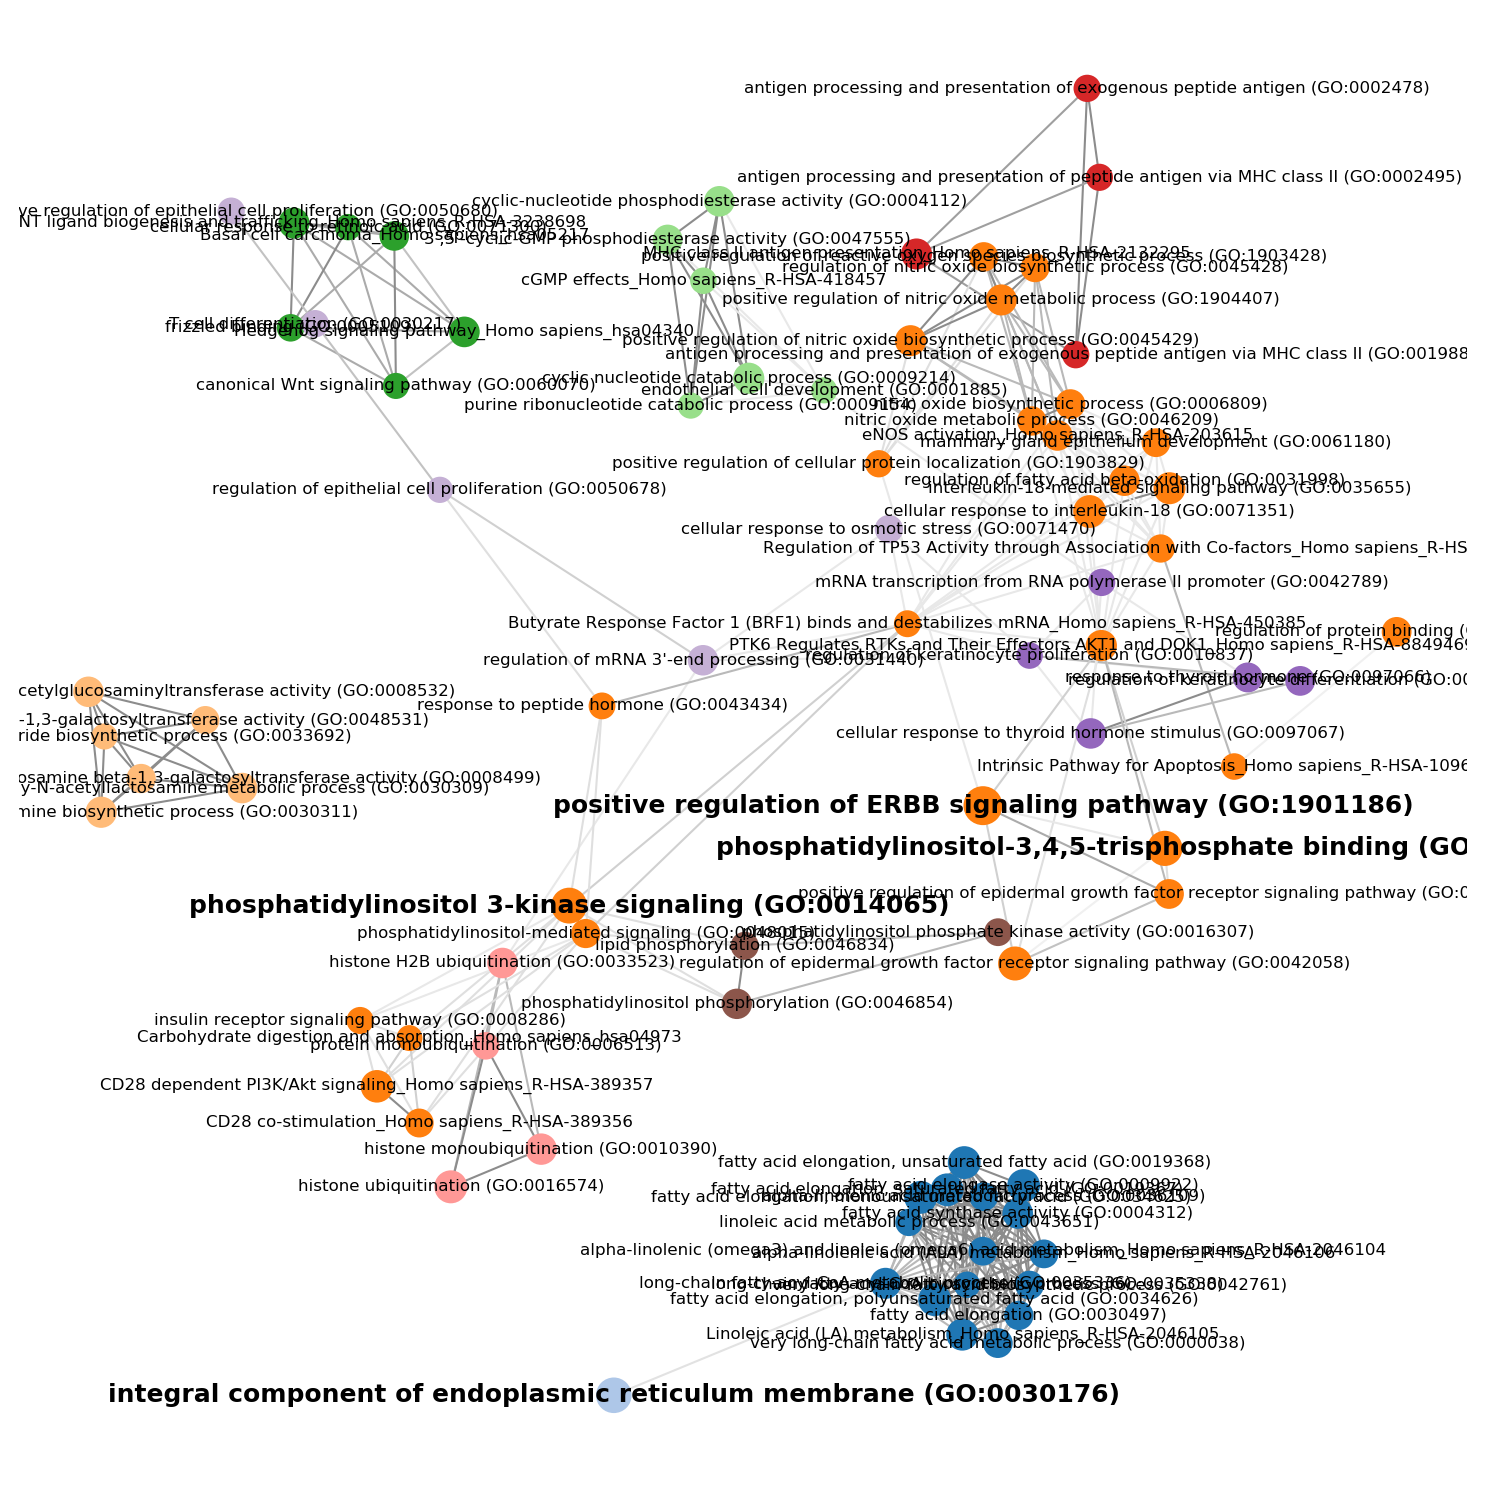

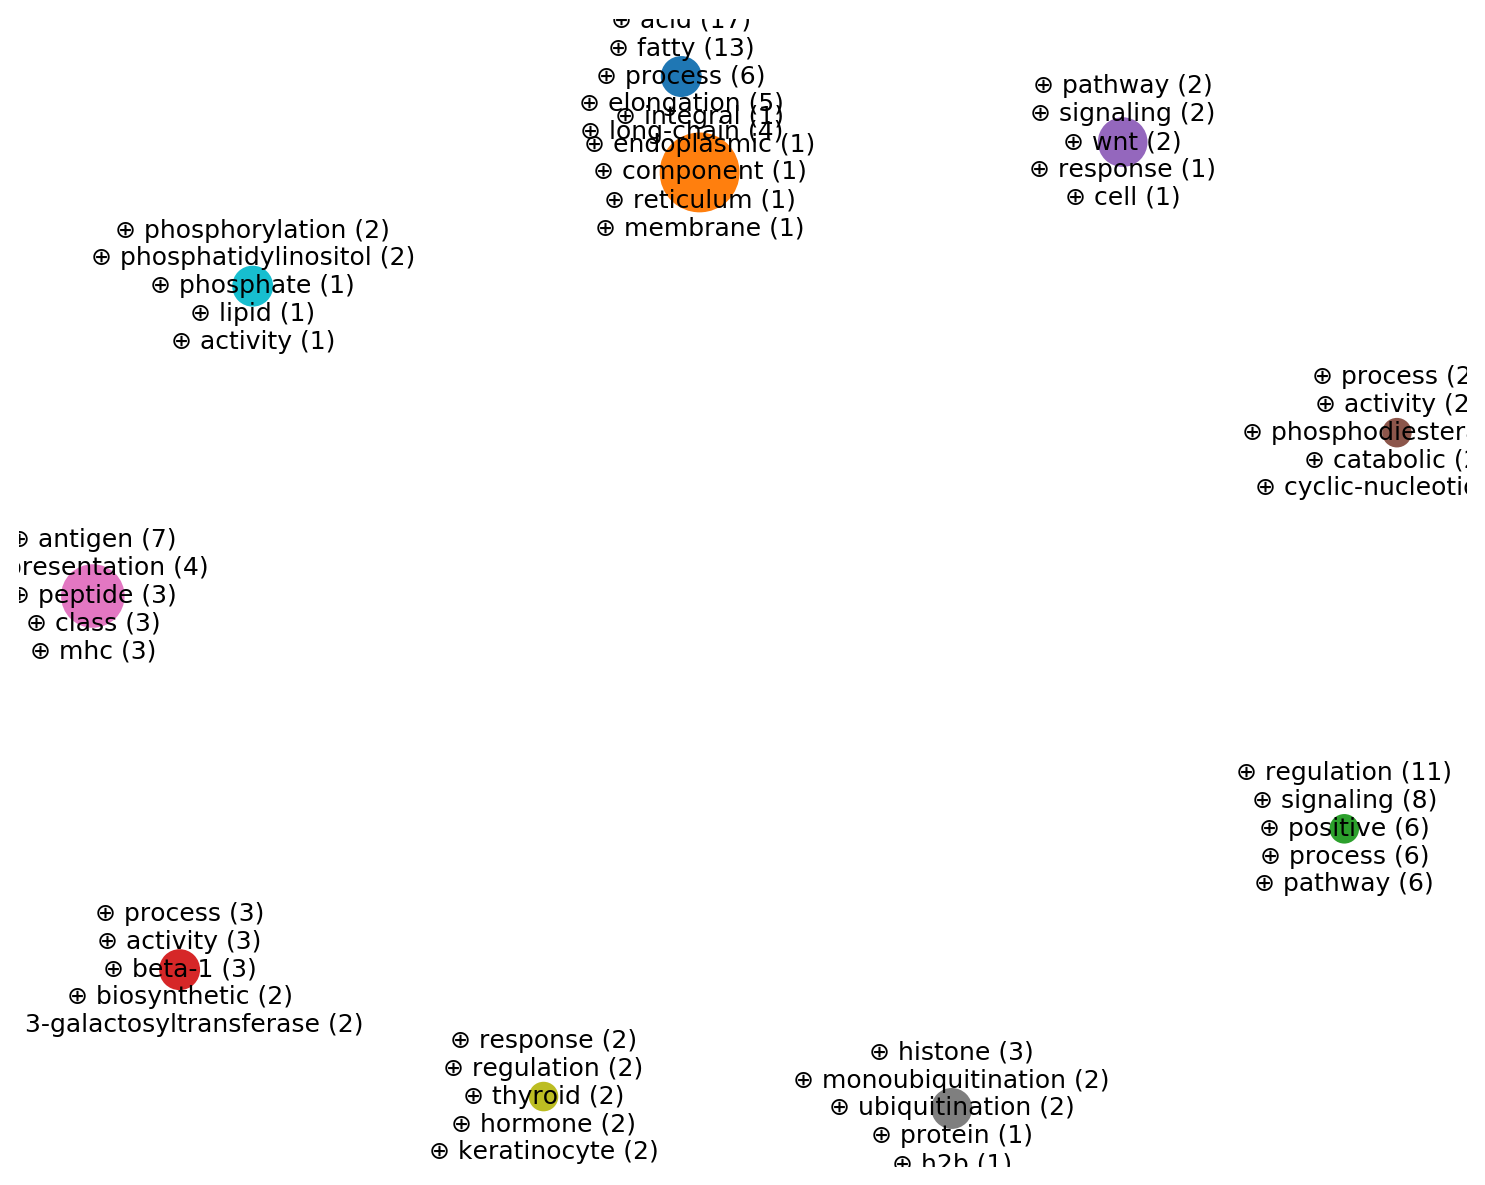

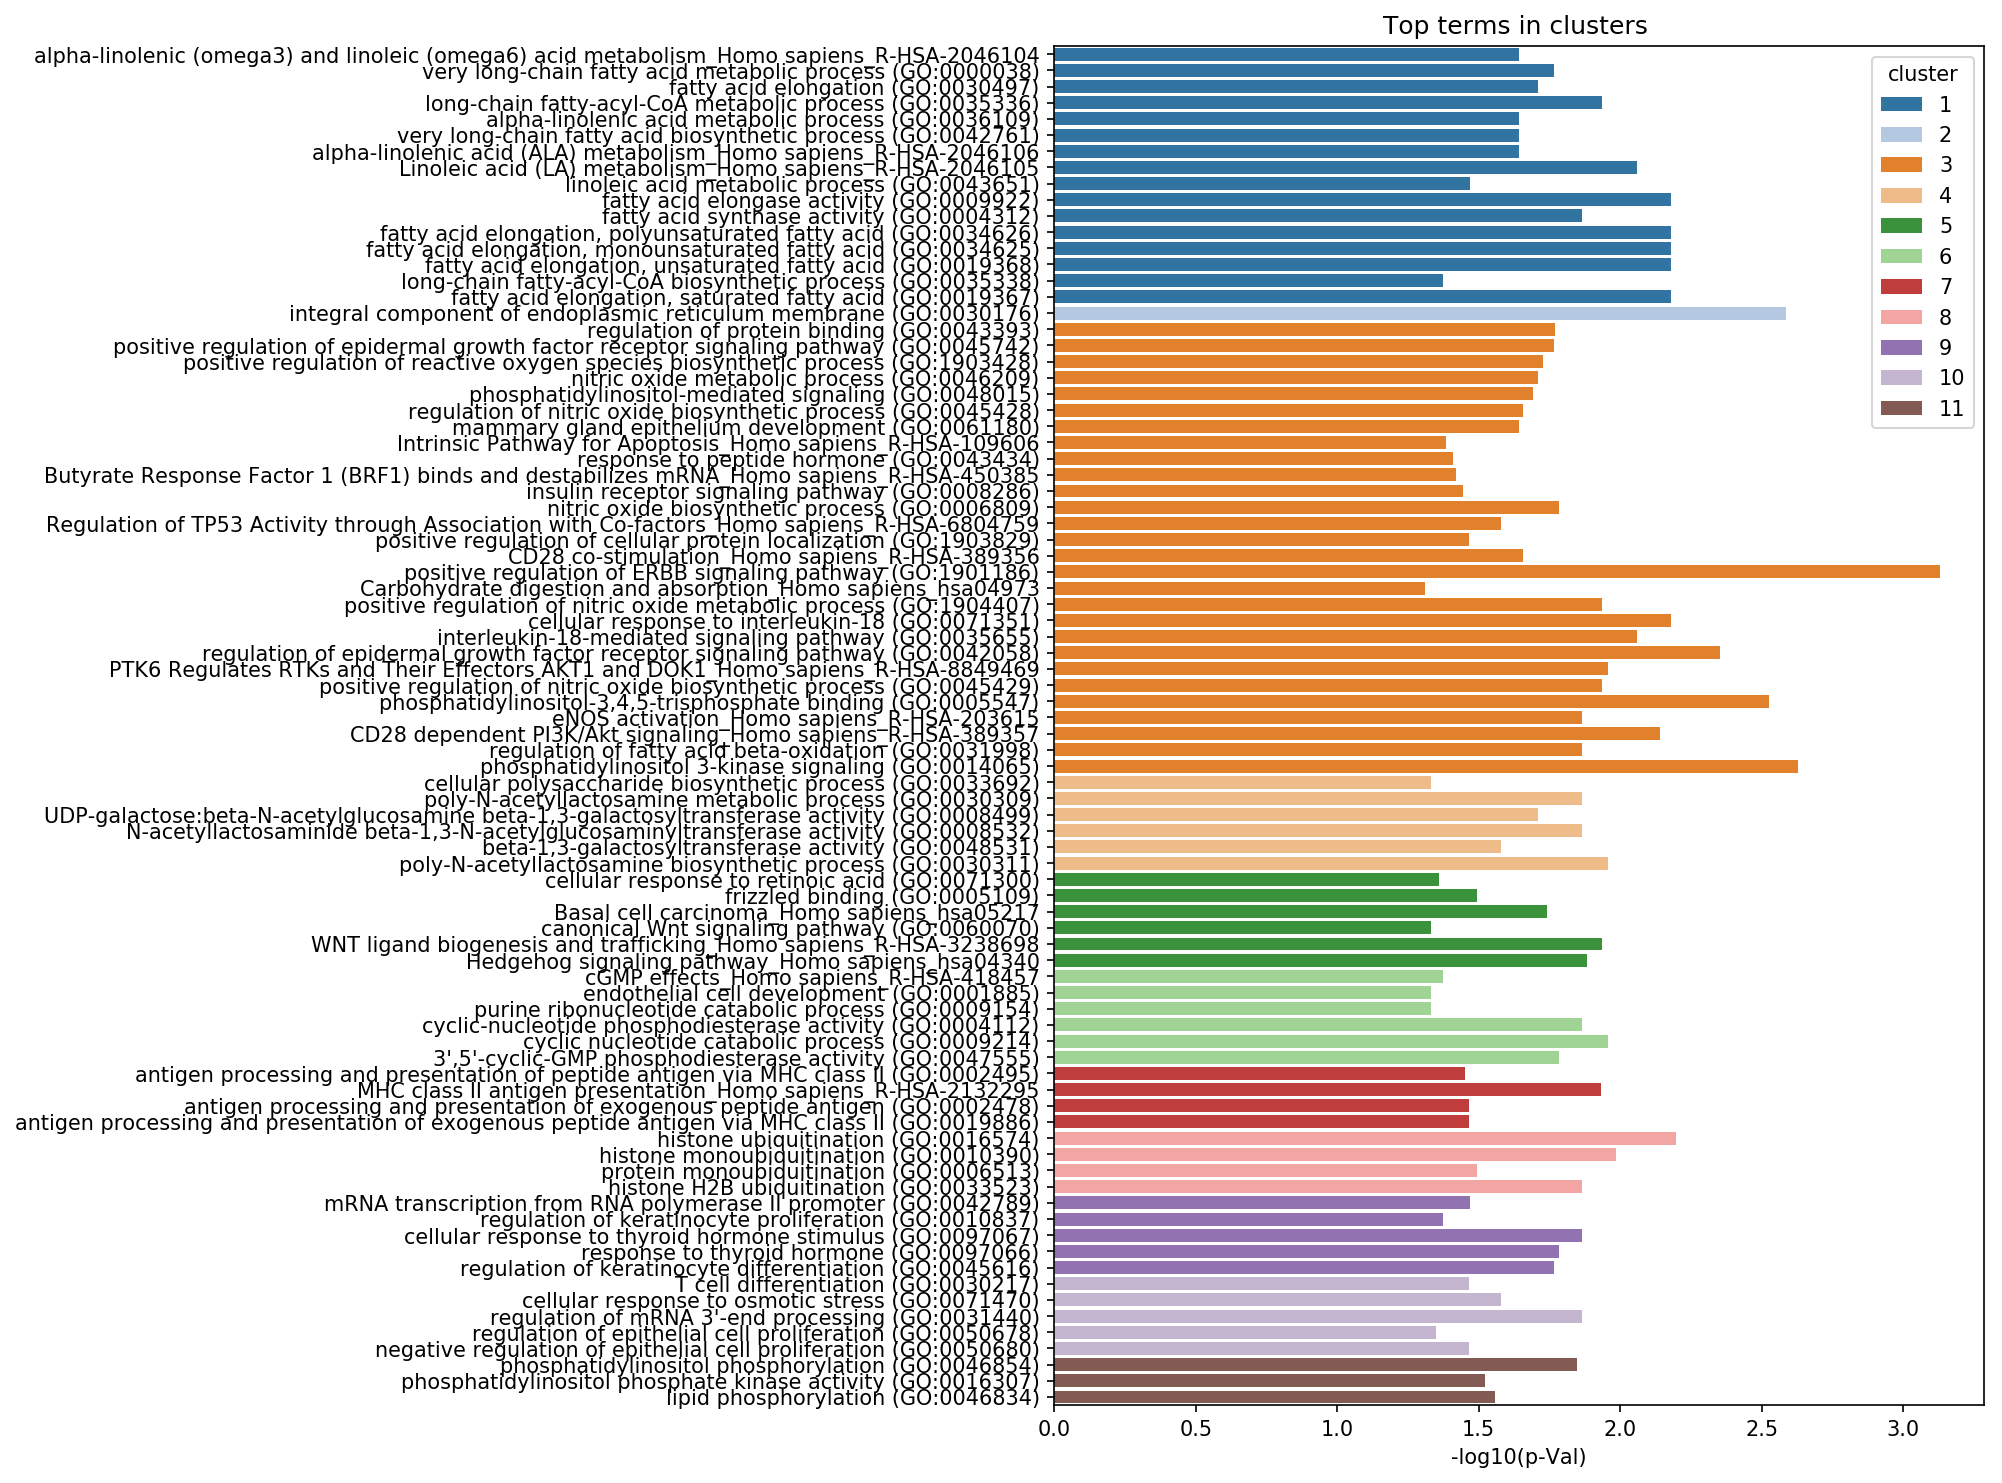

In [49]:
cluser_enrich(enr_genes_mut_tf_prom, genes_mut_tf_prom, top_clusters=12, spring=10) 